<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# 9.02 Lab: Forecasting 

_Authors: Jeff Hale_

---

Let's practice time series forecasting.

---

### Data 

The Rossmann dataset.

---

Goal: forecast total daily sales for the Rossmann stores for 2015. This is a univariate time series problem. 

#### Get the data ready for modeling



In [231]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels as sm

import sktime
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.datasets import load_airline
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting.forecasting import plot_ys
from sklearn.metrics import mean_absolute_error as mae

import statsmodels
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

import pmdarima as pmd
from pmdarima.utils import tsdisplay

In [202]:
df = pd.read_csv('./data/rossmann.csv')

c:\users\cmo\anaconda3\envs\sktime\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [117]:
statsmodels.__version__

'0.12.0'

In [118]:
sktime.__version__

'0.4.2'

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [203]:
df['Date'] = pd.to_datetime(df['Date'])

In [132]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [204]:
df.set_index('Date', inplace=True)

In [205]:
df.sort_index(inplace=True)

In [206]:
df

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,1115,2,0,0,0,0,a,1
2013-01-01,379,2,0,0,0,0,a,1
2013-01-01,378,2,0,0,0,0,a,1
2013-01-01,377,2,0,0,0,0,a,1
2013-01-01,376,2,0,0,0,0,a,1
...,...,...,...,...,...,...,...,...
2015-07-31,746,5,9082,638,1,1,0,1
2015-07-31,747,5,10708,826,1,1,0,1
2015-07-31,748,5,7481,578,1,1,0,1


In [207]:
df.drop(columns=['Store', 'DayOfWeek', 'Customers','Open', 'Promo', 'StateHoliday', 'SchoolHoliday'], inplace=True)

In [208]:
df.shape

(1017209, 1)

#### Split the data into training and test sets. Make the 2015 data the test set.

In [210]:
train = df.loc[:'2014'] 

In [211]:
train.tail()

,Sales
Date,
2014-12-31,4265
2014-12-31,4066
2014-12-31,4415
2014-12-31,3753
2014-12-31,1812


In [199]:
train.shape

(201400, 1)

In [212]:
test = df.loc['2015'] 

In [213]:
test.shape

(236380, 1)

#### Plot the training and test set sales over time.

In [214]:
y_train = train.groupby('Date')['Sales'].sum()

In [215]:
y_test = test.groupby('Date')['Sales'].sum()

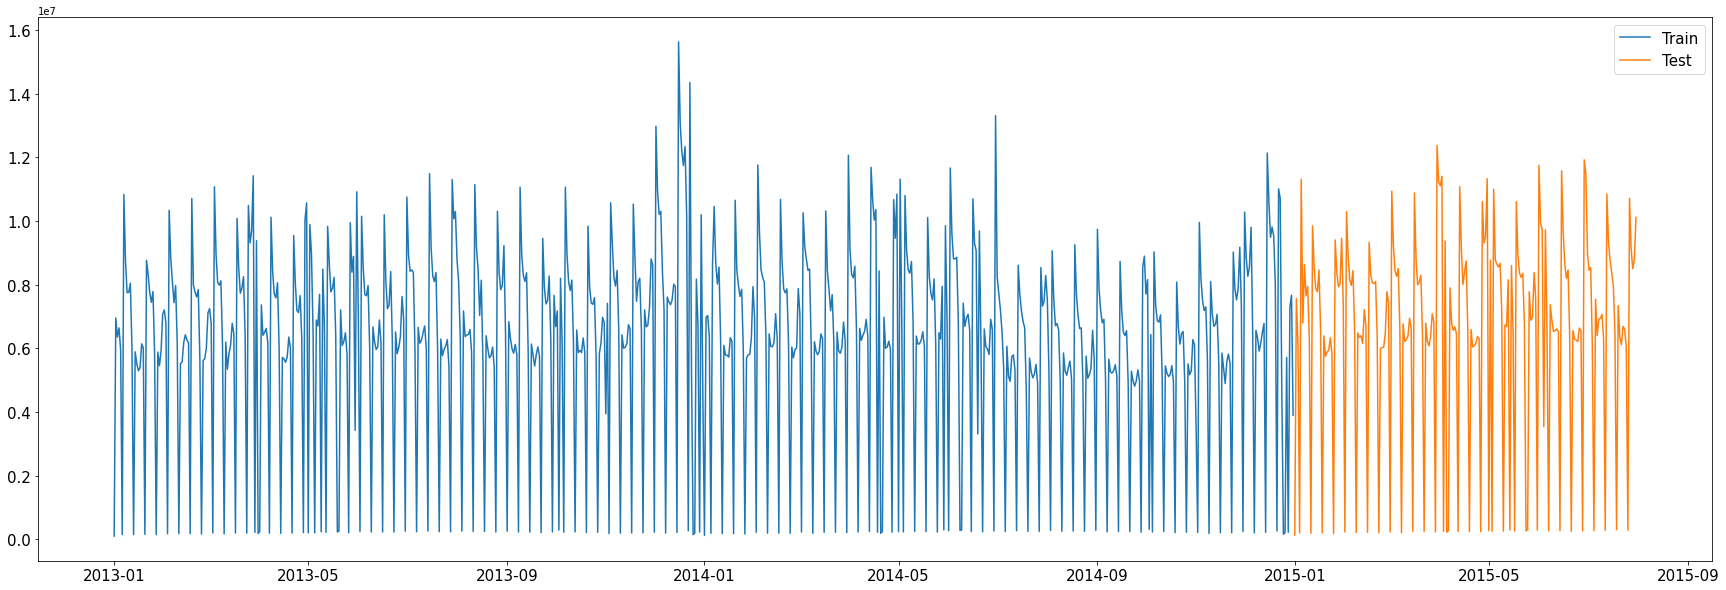

In [150]:
plt.figure(figsize = (30, 10))

plt.plot(y_train.index, y_train, label = 'Train')
plt.plot(y_test.index, y_test, label = 'Test')
#labels
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.legend(fontsize = 15);

In [217]:
y_test, y_train

(Date
 2015-01-01      130162
 2015-01-02     7561431
 2015-01-03     6150311
 2015-01-04      197193
 2015-01-05    11303805
                 ...   
 2015-07-27    10707292
 2015-07-28     9115073
 2015-07-29     8499962
 2015-07-30     8798854
 2015-07-31    10109742
 Name: Sales, Length: 212, dtype: int64,
 Date
 2013-01-01      97235
 2013-01-02    6949829
 2013-01-03    6347820
 2013-01-04    6638954
 2013-01-05    5951593
                ...   
 2014-12-27    5710292
 2014-12-28     218071
 2014-12-29    7291426
 2014-12-30    7665743
 2014-12-31    3895591
 Name: Sales, Length: 730, dtype: int64)

## Baseline (naive) models

#### Make baseline models that are the mean, last value, and seasonal. Plot the predictions on the test set.

I strongly suggest you use sktime to make the forecasts and plot the predicitons.


#### Score your models on the test set using MAE.

In [218]:
df2 = pd.concat([y_train, y_test] )

In [219]:
df2

Date
2013-01-01       97235
2013-01-02     6949829
2013-01-03     6347820
2013-01-04     6638954
2013-01-05     5951593
                ...   
2015-07-27    10707292
2015-07-28     9115073
2015-07-29     8499962
2015-07-30     8798854
2015-07-31    10109742
Name: Sales, Length: 942, dtype: int64

In [220]:
df2 = df2.reset_index(drop=True)

In [187]:
# df2 = df.reset_index(drop=True)

In [221]:
y_train= df2.iloc[:730]
y_test = df2.iloc[731:]

In [222]:
y_train

0        97235
1      6949829
2      6347820
3      6638954
4      5951593
        ...   
725    5710292
726     218071
727    7291426
728    7665743
729    3895591
Name: Sales, Length: 730, dtype: int64

In [223]:
 y_test

731     7561431
732     6150311
733      197193
734    11303805
735     6791481
         ...   
937    10707292
938     9115073
939     8499962
940     8798854
941    10109742
Name: Sales, Length: 211, dtype: int64

In [167]:
df

,Sales
0,0
1,0
2,0
3,0
4,0
...,...
1017204,9082
1017205,10708
1017206,7481
1017207,10460


In [224]:
naive_model_last = NaiveForecaster(strategy='last')
naive_model_last.fit(y_train)


NaiveForecaster()

In [225]:
y_last_preds = naive_model_last.predict(list(range(1, len(y_test)+1)))

In [226]:
naive_model_mean = NaiveForecaster(strategy='mean')
naive_model_mean.fit(y_train)
y_mean_preds = naive_model_mean.predict(list(range(1, len(y_test)+1)))

In [227]:
naive_model_season = NaiveForecaster(strategy='last', sp=12)
naive_model_season.fit(y_train)
y_season_preds = naive_model_season.predict(list(range(1, len(y_test)+1)))

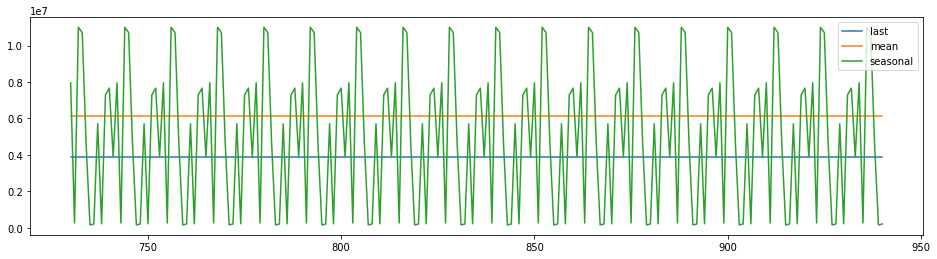

In [230]:
plot_ys(y_last_preds, y_mean_preds, y_season_preds, labels=['last', 'mean', 'seasonal']);

In [246]:
mae_naive_last = mae(y_test, y_last_preds)
mae_naive_last

3904175.27014218

In [253]:
mae_naive_mean = mae(y_test, y_mean_preds)
mae_naive_mean

In [255]:
mae_naive_seasonal = mae(y_test, y_season_preds)
mae_naive_seasonal

4319432.218009478

## Holt-Winters

#### Make a model using Holt-Winters (triple exponential smoothing). Use statsmodels, pmdarima, or sktime. 

In [232]:
hw = ExponentialSmoothing(y_train,seasonal_periods = 365,trend = 'mul',seasonal = 'add').fit()
hw.summary()

c:\users\cmo\anaconda3\envs\sktime\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\users\cmo\anaconda3\envs\sktime\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\users\cmo\anaconda3\envs\sktime\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Dep. Variable:,Sales,No. Observations:,730
Model:,ExponentialSmoothing,SSE,7060126063849777.000
Optimized:,True,AIC,22565.142
Trend:,Multiplicative,BIC,24259.976
Seasonal:,Additive,AICC,23336.159
Seasonal Periods:,365,Date:,"Mon, 09 Nov 2020"
Box-Cox:,False,Time:,16:12:40
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0050000,alpha,True
smoothing_trend,0.0001,beta,True


In [236]:
hw_preds = hw.forecast(len(y_test))

In [237]:
hw_preds

730   -3.312611e+05
731    6.521980e+06
732    5.920681e+06
733    6.212363e+06
734    5.525096e+06
           ...     
936    5.951127e+06
937    5.129175e+06
938   -8.527352e+04
939    1.098075e+07
940    9.746556e+06
Length: 211, dtype: float64

#### Plot the test set predictions vs. actuals.

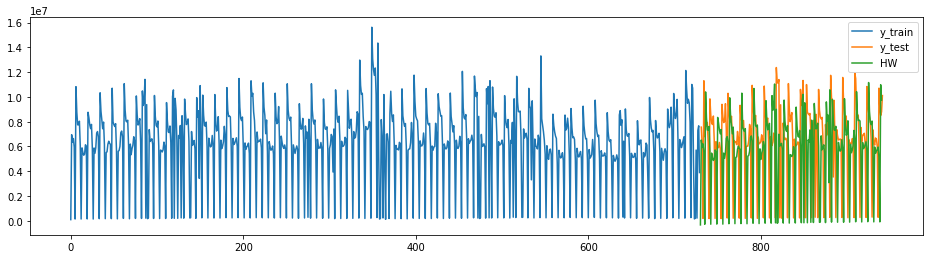

In [238]:
plot_ys(y_train, y_test, hw_preds, labels=['y_train', 'y_test', 'HW']);

#### Score your models on the test set using MAE. 

In [249]:
mae_hw = mae(y_test, hw_preds)
mae_hw

3653126.5489671356

## SARIMA
#### Make a model using SARIMA. Use statsmodels, pmdarima, or sktime. 

In [240]:
sarima_model = AutoARIMA(sp=12, suppress_warnings=True)
sarima_model.fit(y_train)

AutoARIMA(sp=12, suppress_warnings=True)

In [241]:
y_sarima = sarima_model.predict(np.arange(len(y_test)) + 1)

#### Plot the test set predictions vs. actuals.

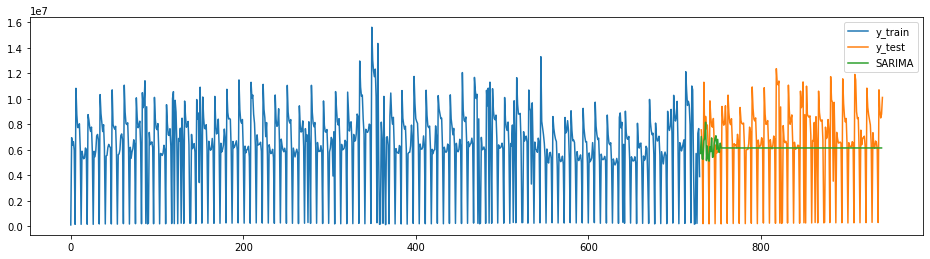

In [244]:
plot_ys(y_train, y_test, y_sarima, labels=['y_train', 'y_test', 'SARIMA']);

#### Score your models on the test set using MAE. 

In [251]:
mae_sarima = mae(y_test, y_sarima)
mae_sarima

2460205.1764707677

#### Which model performs best?

In [277]:
print('Last:', mae_naive_last, "\n"
      'Mean:', mae_naive_mean, "\n"
      'Seasonal:', mae_naive_seasonal, "\n"
      'Holt Winter:', mae_hw, "\n"
      'SARIMA:', mae_sarima)

Last: 3904175.27014218 
Mean: 2443799.523274686 
Seasonal: 4319432.218009478 
Holt Winter: 3653126.5489671356 
SARIMA: 2460205.1764707677


**A:** 
Sarima performed best 